<a href="https://colab.research.google.com/github/AnandKhandekar/Introduction-to-PyMC3--01/blob/master/Intro_to_PyMC3_02(Fonnesbeck).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**The following is an example by CHRIS FONNESBECK in his article**

# Example: Linear Regression

To introduce model definition, fitting and posterior analysis, we first consider a simple Bayesian linear regression model with normal priors on the parameters. We are interested in predicting outcomes $Y$ as normally-distributed observations with an expected value $μ$ that is a linear function of two predictor variables,  $X1$ and $X2$.
* $Y∼N(μ,σ^2)$ 
* $μ=α+β_1X_1+β_2X_2$

where α is the intercept, and $β_i$ is the coefficient for covariate $X_i$, while σ represents the observation or measurement error. We will apply zero-mean normal priors with variance of 10 to both regression coefficients, which corresponds to weak information regarding the true parameter values. Since variances must be positive, we will also choose a half-normal distribution (normal distribution bounded below at zero) as the prior for σ.

* $α∼N(0,10)$
* $βi∼N(0,10)$
* $ σ∼|N(0,1)|$



# Installing the required DEPENDENCIES

This needs to be done for every notebook in Colab and the RUNTIME must be RESTARTED

In [13]:
!pip install arviz==0.6.1
!pip install pymc3==3.8
!pip install Theano==1.0.4

     |████████████████████████████████| 1.4MB 2.7MB/s 
     |████████████████████████████████| 4.1MB 12.9MB/s 
     |████████████████████████████████| 327kB 32.5MB/s 
     |████████████████████████████████| 911kB 2.5MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


# Generating DATA

We can simulate some data from this model using NumPy’s random module, and then use PyMC3 to try to recover the corresponding parameters. The following code implements this simulation, and the resulting data are shown in Fig. 1 below


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm

In [0]:
# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.linspace(0, 1, size)
X2 = np.linspace(0,.2, size)

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

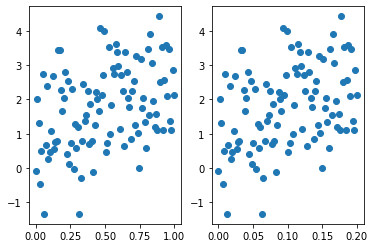

In [16]:
plt.subplot(121)
plt.scatter(X1,Y)
plt.subplot(122)
plt.scatter(X2,Y)


# Model Specification

Specifying this model in PyMC3 is straightforward because the syntax is similar to the statistical notation. For the most part, each line of Python code corresponds to a line in the model notation above. First, we import the components we will need from PyMC3.

In [0]:
from pymc3 import Model, Normal, HalfNormal

**the following CODE inplements the Model in PyMC**

In [0]:
with Model() as basic_model:
    # assign PRIORS for unknow model PARAMETERS
    alpha = pm.Normal('alpha',mu= 0, sd = 10)
    beta = pm.Normal('beta',mu= 0, sd = 10, shape = 2 )
    sigma = pm.HalfNormal('sigma', sd = 1)

    # Exppected value of th OUTCOME
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

The first line,



```
 with Model() as basic_model:
```


creates a new Model object which is a container for the model random variables. Following instantiation of the model, the subsequent specification of the model components is performed inside a with statement.

This creates a context manager, with our basic_model as the context, that includes all statements until the indented block ends. This means all PyMC3 objects introduced in the indented code block below the with statement are added to the model behind the scenes. Absent this context manager idiom, we would be forced to manually associate each of the variables with basic_model as they are created, which would result in more verbose code. If you try to create a new random variable outside of a model context manger, it will raise an error since there is no obvious model for the variable to be added to.



```
alpha = Normal('alpha', mu=0, sd=10)
beta = Normal('beta', mu=0, sd=10, shape=2)
sigma = HalfNormal('sigma', sd=1)
```

The first three statements in the context manager create stochastic random variables with Normal prior distributions for the regression coefficients, and a half-normal distribution for the standard deviation of the observations, σ.

These are stochastic because their values are partly determined by its parents in the dependency graph of random variables, which for priors are simple constants, and are partly random, according to the specified probability distribution.

> The Normal constructor creates a normal random variable to use as a prior. The first argument for random variable constructors is always the name of the variable, which should almost always match the name of the Python variable being assigned to, since it can be used to retrieve the variable from the model when summarizing output. The remaining required arguments for a stochastic object are the parameters, which in the case of the normal distribution are the mean $\mu$ and the standard deviation $\sigma$, which we assign hyperparameter values for the model. In general, a distribution’s parameters are values that determine the location, shape or scale of the random variable, depending on the parameterization of the distribution. Most commonly used distributions, such as Beta, Exponential, Categorical, Gamma, Binomial and others, are available as PyMC3 objects, and do not need to be manually coded by the user.


The beta variable has an additional shape argument to denote it as a vector-valued parameter of **size 2**. The shape argument is available for all distributions and specifies the length or shape of the random variable; when unspecified, it defaults to a value of one (i.e., a scalar). **It can be an integer to specify an array, or a tuple to specify a multidimensional array.** For example, shape=(5,7) makes random variable that takes a 5 by 7 matrix as its value.

# Having defined the priors, the next statement creates the expected value mu of the outcomes, specifying the linear relationship:



```
mu = alpha + beta[0]*X1 + beta[1]*X2
```

This creates a **deterministic** random variable, which implies that its value is completely determined by its parents’ values. That is, there is no uncertainty in the variable beyond that which is inherent in the parents’ values. Here, mu is just the sum of the intercept alpha and the two products of the coefficients in beta and the predictor variables, whatever their current values may be.
***
> PyMC3 random variables and data can be arbitrarily added, subtracted, divided, or multiplied together, as well as indexed (extracting a subset of values) to create new random variables. Many common mathematical functions like sum, sin, exp and linear algebra functions like dot (for inner product) and inv (for inverse) are also provided. Applying operators and functions to PyMC3 objects results in tremendous model expressivity.
***

The final line of the model defines Y_obs, the **sampling distribution of the response data.**

```
Y_obs = Normal('Y_obs', mu=mu, sd=sigma, observed=Y)
```
## **This is a special case of a stochastic variable that we call an observed stochastic, and it is the data likelihood of the model.**

>It is identical to a standard stochastic, except that its observed argument, which passes the data to the variable, indicates that the values for this variable were observed, and should not be changed by any fitting algorithm applied to the model. The data can be passed in the form of either a numpy.ndarray or pandas.DataFrame object.

Notice that, **unlike** the prior distributions, **the parameters for the normal distribution of Y_obs are not fixed values**, but rather are the deterministic object mu and the stochastic sigma. This creates parent-child relationships between the likelihood and these two variables, as part of the directed acyclic graph of the model.


***
## **Model fitting**

***
Having completely specified our model, the **next step** is to **obtain posterior estimates for the unknown variables in the model**. Ideally, we could derive the posterior estimates analytically, but for most non-trivial models this is not feasible. We will consider two approaches, whose appropriateness depends on the structure of the model and the goals of the analysis: 
* finding the maximum a posteriori (MAP) point using optimization methods, 
* and computing summaries based on samples drawn from the posterior distribution using MCMC sampling methods.

## Maximum a posteriori

The maximum a posteriori (MAP) estimate for a model, is the mode of the posterior distribution and is generally found using numerical optimization methods. This is often fast and easy to do, but only gives a point estimate for the parameters and can be misleading if the mode isn’t representative of the distribution. **PyMC3 provides this functionality with the find_MAP function.**

Below we find the **MAP** for our original model. The MAP is returned as **a parameter point**, which is always represented by a **Python dictionary** of variable names to NumPy arrays of parameter values.

In [6]:
from pymc3 import find_MAP

map_estimate = find_MAP(model=basic_model)

print(map_estimate)

logp = -164.8, ||grad|| = 7.6774: 100%|██████████| 17/17 [00:00<00:00, 1355.81it/s]  


{'alpha': array(1.01365899), 'beta': array([1.46792489, 0.29358498]), 'sigma_log__': array(0.11438772), 'sigma': array(1.12118675)}


By default, find_MAP uses the Broyden–Fletcher–Goldfarb–Shanno (BFGS) optimization algorithm to find the maximum of the log-posterior but also allows selection of other optimization algorithms from the scipy.optimize module. For example, below we use Powell’s method to find the MAP.

In [7]:
from scipy import optimize

map_estimate = find_MAP(model=basic_model, fmin=optimize.fmin_powell)

print(map_estimate)

/usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:116: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  "In future versions, set the optimization algorithm with a string. "
logp = -164.5:   5%|▌         | 271/5000 [00:00<00:01, 2573.91it/s]

Optimization terminated successfully.
         Current function value: 164.496957
         Iterations: 6
         Function evaluations: 271
{'alpha': array(1.01761779), 'beta': array([1.51424081, 0.03486478]), 'sigma_log__': array(0.11323002), 'sigma': array(1.1198895)}


# **Sampling Methods**

## **Gradient based Sampling Methods**

**NUTS : No-U-Turn-Sampling.**
Here, we will use NUTS to sample 2000 draws from the posterior using the MAP as the starting and scaling point. Sampling must also be performed inside the context of the model.

In [8]:
from pymc3 import NUTS, sample

with basic_model:

    # obtain starting values via MAP
    start = find_MAP(fmin=optimize.fmin_powell)

    # instantiate sampler
    step = NUTS(scaling=start)

    # draw 2000 posterior samples
    trace = sample(2000, step, start=start)

/usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:116: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  "In future versions, set the optimization algorithm with a string. "
logp = -164.5:   5%|▌         | 271/5000 [00:00<00:02, 2288.24it/s]


Optimization terminated successfully.
         Current function value: 164.496957
         Iterations: 6
         Function evaluations: 271


Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 2500/2500 [00:06<00:00, 386.32it/s]
The number of effective samples is smaller than 25% for some parameters.


The sample function runs the step method(s) passed to it for the given number of iterations and returns a Trace object containing the samples collected, in the order they were collected. The trace object can be queried in a similar way to a dict containing a map from variable names to numpy.array s. The first dimension of the array is the sampling index and the later dimensions match the shape of the variable. We can extract the last 5 values for the alpha variable as follows

In [9]:
trace['alpha'][-5:]

array([0.97436401, 1.07928372, 0.75634408, 1.12392951, 1.31398479])

In [10]:
trace['beta'][-5:]

array([[ -1.38650214,  15.04767008],
       [  4.6598515 , -16.06039161],
       [  4.99638427, -15.5789324 ],
       [  6.72851513, -26.51595229],
       [  6.40703565, -26.707213  ]])

# Posterior analysis
PyMC3 provides plotting and summarization functions for inspecting the sampling output. A simple posterior plot can be created using traceplot, its output is shown in Fig. 2.

/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8beb821048>,
      dtype=object)

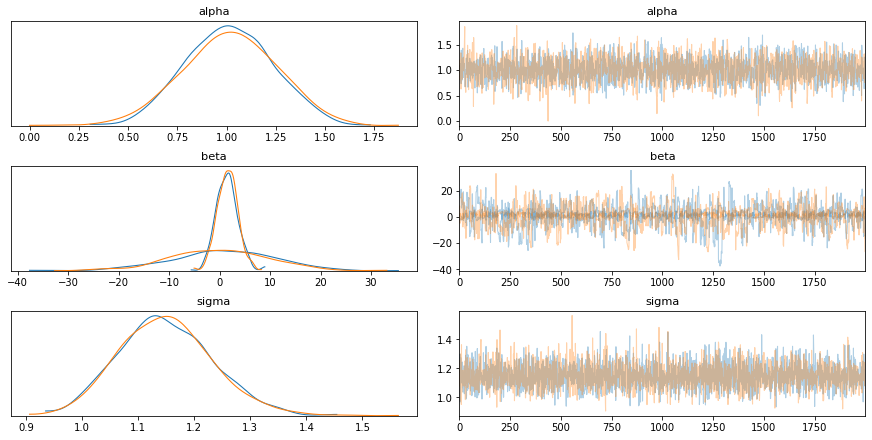

In [11]:
from pymc3 import traceplot

traceplot(trace)

The left column consists of a smoothed histogram (using kernel density estimation) of the marginal posteriors of each stochastic random variable while the right column contains the samples of the Markov chain plotted in sequential order. The beta variable, being vector-valued, produces two histograms and two sample traces, corresponding to both predictor coefficients.

In [15]:
#For a tabular summary, the summary function provides a text-based output
# of common posterior statistics:

from pymc3 import summary

summary(trace['alpha'])

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,1.012,0.232,0.585,1.44,0.005,0.003,2309.0,2309.0,2324.0,2139.0,NaN
